<a href="https://colab.research.google.com/github/cuwihhhhh/BengBOT/blob/main/model_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model LSTM**  

===============================================================


Download data dari github

In [1]:
# Download dataset dari GitHub
from urllib import request
url = "https://raw.githubusercontent.com/cuwihhhhh/datasetkel3/main/Dataset.json"
request.urlretrieve(url, "Dataset3.json")

('Dataset3.json', <http.client.HTTPMessage at 0x7e599b3a0cd0>)

Load GDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


===============================================================



In [3]:
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D
from tensorflow.keras.layers import Input

In [4]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
# Importing the dataset
with open('/content/Dataset3.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter
# Tambahkan data intents dalam json
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    # digunakan untuk pattern atau teks pertanyaan dalam json
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # tambahkan ke dalam list kelas dalam data
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [6]:
# Cetak data keseluruhan
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,hei,greeting
3,Hi,greeting
4,hi,greeting
...,...,...
572,saya mau kredit motor syaratnya apa?,Kredit_motor
573,kredit motor yamaha dengan bunga rendah?,Kredit_motor
574,gimana caranya mengajukan kredit motor?,Kredit_motor
575,apa yang di butuhkan untuk kredit motor?,Kredit_motor


In [7]:
# Cetak data baris pertama sampai baris kelima
data.head()

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,hei,greeting
3,Hi,greeting
4,hi,greeting


In [8]:
# Cetak data baris ke-70 sampai baris akhir
data.tail()

,patterns,tags
572,saya mau kredit motor syaratnya apa?,Kredit_motor
573,kredit motor yamaha dengan bunga rendah?,Kredit_motor
574,gimana caranya mengajukan kredit motor?,Kredit_motor
575,apa yang di butuhkan untuk kredit motor?,Kredit_motor
576,mengajukan kredit motor,Kredit_motor


In [9]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

In [10]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

410 unique lemmatized words [',', '/', '155', '24', '42', '7', 'a', 'ada', 'aerox', 'aftermarket', 'afternoon', 'agar', 'aja', 'aki', 'aksesoris', 'alamat', 'aneh', 'angin', 'anti', 'apa', 'apakah', 'arti', 'asli', 'asuransi', 'awet', 'bagaimana', 'bagian', 'bagus', 'bahan', 'baik', 'bakar', 'ban', 'banget', 'bangkel', 'bantu', 'bantuan', 'banyak', 'basah', 'bawaan', 'begal', 'bekerja', 'beli', 'benar', 'bengbot', 'bengkel', 'bensin', 'bentuk', 'berapa', 'berat', 'bergaransi', 'berikan', 'berisi', 'berkala', 'bersih', 'biasanya', 'biaya', 'biayanya', 'bisa', 'bisakah', 'boleh', 'booking', 'bore', 'boros', 'brisik', 'buat', 'buka', 'bunga', 'bunyi', 'busi', 'butuhkan', 'bye', 'byson', 'cadang', 'cakep', 'cakram', 'cara', 'caranya', 'cocok', 'cocoknya', 'copot', 'cvt', 'dadah', 'dah', 'dahulu', 'dalam', 'dan', 'dari', 'darurat', 'datang', 'dengan', 'di', 'diberikan', 'dibutuhkan', 'diganti', 'digunakan', 'diisi', 'dikerjakan', 'dilakukan', 'dimana', 'dinyalakan', 'dipakai', 'diperhatikan

In [11]:
# sorting pada data class
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

95 classes ['Aki', 'Bengbot', 'Cakram motor', 'Filter Oli', 'Harga Oli', 'Indikator Kunci NMAX', 'Kampas kopling', 'Klaim_Asuransi', 'Kode_Kerusakan', 'Kredit_motor', 'Mesin bunyi', 'Oli Motor', 'Pusat_Servis', 'Remot_NMAX', 'Stang motor', 'Ukuran_Aki_NMAX', 'Yamalube oli', 'aki bawaan', 'aksesoris_motor', 'ban_motor', 'bensin', 'bore up', 'diskon_AkhirTahun', 'ganti shock', 'goodbye', 'greeting', 'harga_service', 'informasi_knalpot_aerox', 'informasi_knalpot_nmax', 'informasi_knalpot_r15', 'informasi_knalpot_vixion', 'informasi_layanan', 'jadwal_bengkel', 'jam_operasional', 'jasa_home_service', 'jenis_knalpot_lainnya_byson', 'jenis_knalpot_lainnya_fino', 'jenis_knalpot_lainnya_lexi', 'jenis_knalpot_lainnya_scorpio', 'jenis_knalpot_tambahan_jupmx', 'jenis_knalpot_tambahan_mt25', 'jenis_knalpot_tambahan_r25', 'jenis_knalpot_tambahan_xmax', 'jenis_oli', 'keluhan', 'kemanan motor', 'ketersediaan_suku_cadang', 'kode motor 42', 'layanan Service', 'layanan_darurat', 'layanan_konsultasi', 'la

In [12]:
# documents = kombinasi antara data pattern dengan data tag dalam intents json
print (len(documents), "documents")

3605 documents


In [13]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[271],
 [272],
 [273],
 [158],
 [158],
 [158, 3, 5, 14, 15, 274],
 [158, 3, 215],
 [275],
 [3, 215],
 [276],
 [216],
 [277],
 [278],
 [279],
 [280],
 [281],
 [282],
 [283],
 [182, 217],
 [183],
 [284, 285],
 [182, 217, 286, 287],
 [183, 183],
 [182, 218],
 [288, 289, 290],
 [291, 218],
 [219, 292],
 [219, 293],
 [294, 220],
 [35, 11, 60, 295, 184],
 [53, 11, 60],
 [67, 12, 11, 60],
 [35, 11, 60, 138, 184, 296],
 [11, 185, 184, 3],
 [11, 67, 297, 216, 60, 18],
 [185, 67, 12, 11],
 [3, 24, 85, 28, 27, 92, 5, 72, 6, 11, 1],
 [35, 11, 86, 28, 27, 92],
 [221, 28, 27, 3, 24, 5, 72, 6, 11],
 [3, 24, 28, 27, 5, 14, 15, 139, 6, 11, 1],
 [25, 139, 222, 92],
 [20, 222, 18, 6, 11],
 [11, 1, 298, 223, 4, 21, 13],
 [20, 299, 4, 13, 6, 11, 1],
 [20, 223, 21, 6, 11, 1],
 [13, 6, 11, 1, 224],
 [25, 13, 6, 1, 20, 300, 18],
 [11, 1, 224, 68, 159, 13, 301],
 [225, 226, 2, 15, 54, 3, 5, 26, 15, 227],
 [2, 15, 302, 160, 186, 55, 3, 5, 14, 45],
 [16, 17, 228, 160, 138, 2, 15],
 [3, 5, 26, 15, 227, 159, 2, 1

In [14]:
# Melakukan proses padding pada data
x_train = pad_sequences(train)
# Menampilkan hasil padding
print(x_train)

[[  0   0   0 ...   0   0 271]
 [  0   0   0 ...   0   0 272]
 [  0   0   0 ...   0   0 273]
 ...
 [  0   0   0 ... 171 113   2]
 [  0   0   0 ...   4 113   2]
 [  0   0   0 ... 171 113   2]]


In [15]:
# Melakukan konversi data label tags dengan encoding
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train)

[25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 24 24 24 24 24 24 24 24
 80 80 80 80 80 32 32 32 32 32 32 32 79 79 79 79 79 79 51 51 51 51 51 51
 31 31 31 31 31 31 33 33 33 33 33 33 19 19 19 19 19 19 54 54 54 54 54 54
 20 20 20 20 20 20 83 83 83 83 83 83  1  1  1  1  1  1 48 48 48 48 48 48
 21 21 21 21 21 21 23 23 23 23 23 23 16 16 16 16 16 16  4  4  4  4  4  4
 11 11 11 11 11  6  6  6  6  6  6  3  2  2  2  2  2  2 14 14 14 14 14 14
 81 81 81 81 81 81 26 26 26 26 26 26 56 56 56 56 56 56 43 43 43 43 43 43
 71 71 71 71 71 71 66 66 66 66 66 66 22 22 22 22 22 22 49 49 49 49 49 49
 61 61 61 61 61 61 82 82 82 82 82 82 44 44 44 44 44 44 76 76 76 76 76 76
 62 62 62 62 62 62 46 46 46 46 46 46 50 50 50 50 50 50 69 69 69 69 69 69
 60 60 60 60 60 60 55 55 55 55 55 55 63 63 63 63 63 63 18 18 18 18 18 18
 72 72 72 72 72 72 64 64 64 64 64 64 52 52 52 52 52 52 68 68 68 68 68 68
 34 34 34 34 34 34 73 73 73 73 73 73 77 77 77 77 77 77 75 75 75 75 75 75
 70 70 70 70 70 70 57 57 57 57 57 57 78 78 78 78 78

In [16]:
# Melihat hasil input pada data teks
input_shape = x_train.shape[1]
print(input_shape)

11


In [17]:
# Melakukan definisi tiap kalimat dan kata pada data teks
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# Melakukan pemeriksaan pada data output label teks
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  408
output length:  95


In [18]:
# Simpan hasil pemrosesan teks dengan menggunakan pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

In [19]:
pickle.dump(le, open('le.pkl','wb'))
pickle.dump(tokenizer, open('tokenizers.pkl','wb'))

In [20]:
# Creating the model (Membuat Modelling)
i = Input(shape=(input_shape,)) # Layer Input
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True, recurrent_dropout=0.2)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x) # Model yang telah disusun dari layer Input sampai layer Output

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

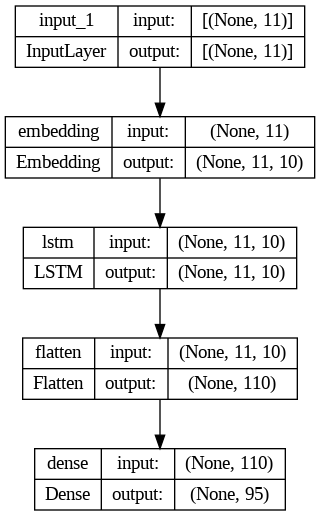

In [21]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
# Menampilkan parameter pada model LSTM
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 embedding (Embedding)       (None, 11, 10)            4090      
                                                                 
 lstm (LSTM)                 (None, 11, 10)            840       
                                                                 
 flatten (Flatten)           (None, 110)               0         
                                                                 
 dense (Dense)               (None, 95)                10545     
                                                                 
Total params: 15475 (60.45 KB)
Trainable params: 15475 (60.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Training the model (Melatih model data sampai 450 kali)
train = model.fit(x_train, y_train, epochs=500)

Epoch 1/500
19/19 [==============================] - 5s 20ms/step - loss: 4.5544 - accuracy: 0.0087
Epoch 2/500
19/19 [==============================] - 0s 20ms/step - loss: 4.5485 - accuracy: 0.0295
Epoch 3/500
19/19 [==============================] - 0s 19ms/step - loss: 4.5423 - accuracy: 0.0277
Epoch 4/500
19/19 [==============================] - 0s 18ms/step - loss: 4.5322 - accuracy: 0.0277
Epoch 5/500
19/19 [==============================] - 0s 20ms/step - loss: 4.5152 - accuracy: 0.0312
Epoch 6/500
19/19 [==============================] - 0s 14ms/step - loss: 4.4802 - accuracy: 0.0329
Epoch 7/500
19/19 [==============================] - 0s 11ms/step - loss: 4.4207 - accuracy: 0.0312
Epoch 8/500
19/19 [==============================] - 0s 12ms/step - loss: 4.3355 - accuracy: 0.0364
Epoch 9/500
19/19 [==============================] - 0s 11ms/step - loss: 4.2341 - accuracy: 0.0416
Epoch 10/500
19/19 [==============================] - 0s 11ms/step - loss: 4.1191 - accuracy: 0.0503

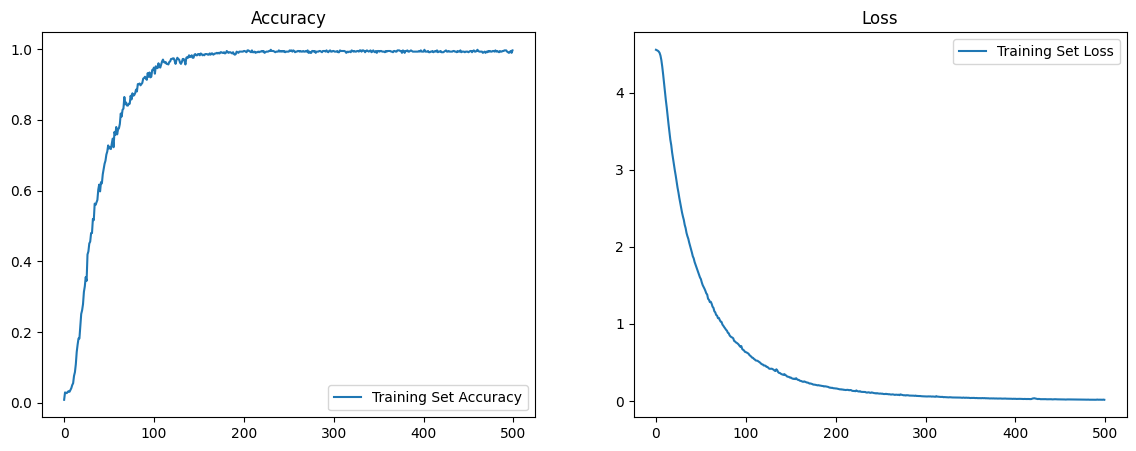

In [24]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [25]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')

  # Menghapus punktuasi atau tanda baca dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Melakukan Tokenisasi dan Padding pada data teks
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  # Konversi data teks menjadi array
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil prediksi keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan suara bot
  response_tag = le.inverse_transform([output])[0]
  # Bot akan melakukan random jawaban percakapan dari hasil pertanyaan
  print("🤖 BengBOT : ", random.choice(responses[response_tag]))
  # Atur waktu jeda sampai 8 detik
  time.sleep(0.08)
  # Ambil file model yang telah disimpan sebelumnya
  print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti melakukan percakapan
  if response_tag == "goodbye":
    break

👨‍🦰 Kamu : hi
1/1 [==============================] - 0s 268ms/step
🤖 BengBOT :  Hai, adakah yang perlu saya bantu

👨‍🦰 Kamu : ada diskon?
1/1 [==============================] - 0s 23ms/step
🤖 BengBOT :  Ya, kami memberikan diskon khusus  sebesar 10% untuk setiap layanan servis dan pembelian spare part setiap ganti tahun

👨‍🦰 Kamu : bye
1/1 [==============================] - 0s 28ms/step
🤖 BengBOT :  Good bye!



In [26]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
model.save('inimodelygy.h5')

print('Model Created Successfully!')

Model Created Successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
